# Which sentiment is reflected by lyrics of english song during political/economical crisis, in countries where that language is primary ? 

## Packages import

In [1]:
import pandas as pd
import pyarrow
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from collections import Counter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np
from nrclex import NRCLex
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import random

## Dataset import

In [ ]:
USE_COLS = [
    "lyrics",
    "year",
    "language_cld3",
    "language_ft",
    "tag",
    "artist",
    "title",
    "views"
]

chunks = []
CHUNK_SIZE = 50_000  

for chunk in pd.read_csv(
    "song_lyrics_filtered.csv",
    usecols=USE_COLS,
    chunksize=CHUNK_SIZE,
    low_memory=True,
    engine="python"  
):
    # filtrage immédiat
    chunk = chunk[
        (chunk["language_cld3"] == "en") &
        (chunk["language_ft"] == "en") &
        (chunk["tag"] == "rap")
    ]
    
    chunks.append(chunk)

df = pd.concat(chunks, ignore_index=True)

print(df.shape)
df.head()

(964605, 8)


,title,tag,artist,year,views,lyrics,language_cld3,language_ft
0,Killa Cam,rap,Cam'ron,2004,173166,"[Chorus: Opera Steve & Cam'ron]\nKilla Cam, Ki...",en,en
1,Can I Live,rap,JAY-Z,1996,468624,"[Produced by Irv Gotti]\n\n[Intro]\nYeah, hah,...",en,en
2,Forgive Me Father,rap,Fabolous,2003,4743,Maybe cause I'm eatin\nAnd these bastards fien...,en,en
3,Down and Out,rap,Cam'ron,2004,144404,[Produced by Kanye West and Brian Miller]\n\n[...,en,en
4,Fly In,rap,Lil Wayne,2005,78271,"[Intro]\nSo they ask me\n""Young boy\nWhat you ...",en,en


In [7]:
# Suppression des colonnes inutiles
df = df.drop(["language_cld3", "language_ft", "tag"], axis=1)

In [8]:
# Enregistrement du df en parquet
df.to_parquet(
    "data/rap_lyrics.parquet",
    index=False
)

In [4]:
# Chargement du df filtré
df = pd.read_parquet("data/rap_lyrics.parquet")
df.head()

,title,artist,year,views,lyrics
0,Killa Cam,Cam'ron,2004,173166,"[Chorus: Opera Steve & Cam'ron]\nKilla Cam, Ki..."
1,Can I Live,JAY-Z,1996,468624,"[Produced by Irv Gotti]\n\n[Intro]\nYeah, hah,..."
2,Forgive Me Father,Fabolous,2003,4743,Maybe cause I'm eatin\nAnd these bastards fien...
3,Down and Out,Cam'ron,2004,144404,[Produced by Kanye West and Brian Miller]\n\n[...
4,Fly In,Lil Wayne,2005,78271,"[Intro]\nSo they ask me\n""Young boy\nWhat you ..."


## Descriptive statistics

In [ ]:
df.info()
# no missing values 

<class 'pandas.DataFrame'>
RangeIndex: 964605 entries, 0 to 964604
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   title   964538 non-null  str  
 1   artist  964605 non-null  str  
 2   year    964605 non-null  int64
 3   views   964605 non-null  int64
 4   lyrics  964605 non-null  str  
dtypes: int64(2), str(3)
memory usage: 2.1 GB


In [11]:
# Dupes check in df
df[df.duplicated(subset=["title", "artist"], keep=False)] \
  .sort_values(["artist", "title"])

,title,artist,year,views,lyrics
754298,WHERES WALDO 2,C.M.L.,2020,5955,"[Mozzy and DJ Vlad Interview]\nVlad: So, how l..."
801101,WHERES WALDO 2,C.M.L.,2021,73,U was laughing at bris now im laughing at sque...
149155,You I,Marsha Ambrosius,2014,240,[Hook]\nYou and I\nCan we get together now\nYo...
149171,You I,Marsha Ambrosius,2014,255,[Chorus]\nYou and I\nCan we get together now?\...
587407,Trauma Grace,Medhane,2019,1806,In between tomorrow and today\nSunshine and im...
593930,Trauma Grace,Medhane,2020,86,[Verse 1]\nIn between tomorrow and today\nSuns...


In [ ]:
# Removing dupes
df = df.drop_duplicates(subset=["title", "artist"], keep="first")
df.shape

In [ ]:
# Descriptive statistics for numerics columns
df[["year", "views"]].describe()
# Incoherence in values for year and views (min)

,year,views
count,964605.000000,9.646050e+05
mean,2014.790266,5.882038e+03
std,57.264063,8.041827e+04
min,1.000000,0.000000e+00
25%,2015.000000,2.000000e+01
50%,2018.000000,6.900000e+01
75%,2020.000000,5.280000e+02
max,2027.000000,1.757563e+07


In [12]:
songs_per_year = df["year"].value_counts().sort_index()
songs_per_year.head()

year
1    649
2      6
3      3
5      1
6      6
Name: count, dtype: int64

In [6]:
# Filter to keep only years between 1950 and 2023
df = df[(df["year"] >= 1950) & (df["year"] <= 2023)]
df.shape

(963628, 5)

In [7]:
df["year"].describe()
# Now, the values make sense

count    963628.000000
mean       2016.463142
std           5.523159
min        1950.000000
25%        2015.000000
50%        2018.000000
75%        2020.000000
max        2023.000000
Name: year, dtype: float64

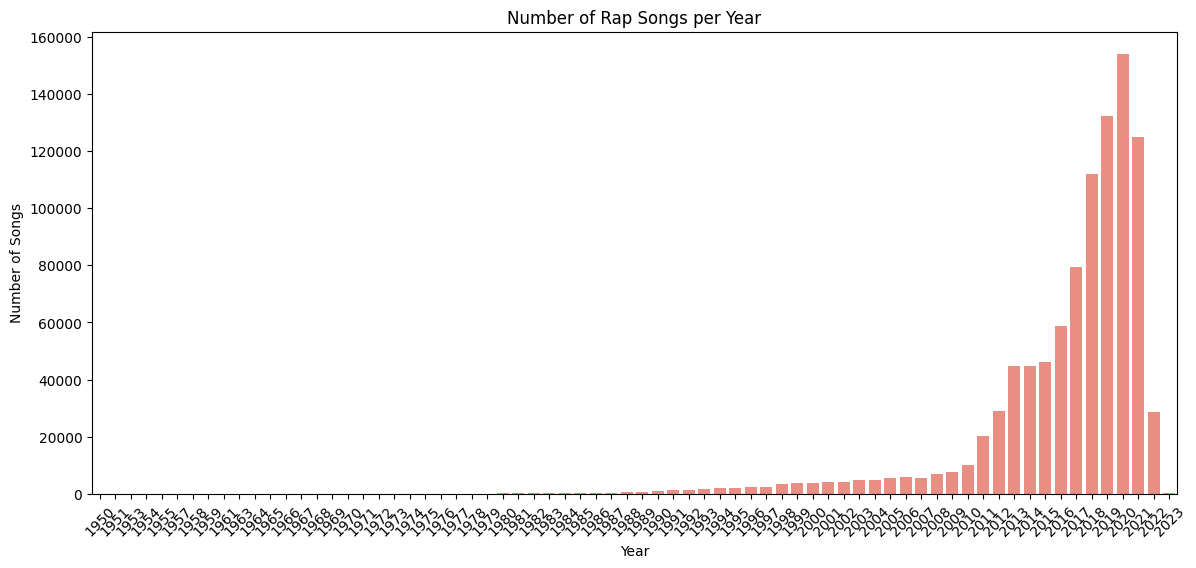

In [4]:
songs_per_year = df["year"].value_counts().sort_index()
plt.figure(figsize=(14,6))
sns.barplot(x=songs_per_year.index, y=songs_per_year.values, color="salmon")
plt.title("Number of Rap Songs per Year")
plt.xlabel("Year")
plt.ylabel("Number of Songs")
plt.xticks(rotation=45)
plt.show()

In [8]:
# Keeping rows only from the year 1980 to 2023
df = df[(df["year"] >= 1980) & (df["year"] <= 2023)]
df["year"].describe()

count    963336.000000
mean       2016.476295
std           5.471202
min        1980.000000
25%        2015.000000
50%        2018.000000
75%        2020.000000
max        2023.000000
Name: year, dtype: float64

In [ ]:
df["artist"].value_counts().head(10)
# Genius English Translations needs to be removed (the originals songs are not in English)

artist
Genius English Translations    3738
Lil B                          1287
Gucci Mane                     1184
Juice WRLD                     1135
Lil Wayne                      1020
Chief Keef                      919
Muze Sikk                       917
OCTOBERSFULLMOON                886
Kanye West                      773
BONES                           773
Name: count, dtype: int64

In [16]:
# Removing Genius translations
mask_artist = ~df["artist"].str.contains(
    "Genius|Translation|Translations",
    case=False,
    na=False
)

# Removing lyrics too small
#mask_length = df["clean_lyrics"].str.split().str.len() >= 50

# Filter
df = df[mask_artist 
        #& mask_length
        ]

# Check
df["artist"].value_counts().head(10)

artist
Lil B               1287
Gucci Mane          1184
Juice WRLD          1135
Lil Wayne           1020
Chief Keef           919
Muze Sikk            917
OCTOBERSFULLMOON     886
Kanye West           773
BONES                773
Young Thug           761
Name: count, dtype: int64

In [ ]:
# Quick check of the title and count coherence
df[df["artist"] == "Lil B"]["title"].value_counts().head(20)

title
Look Like Jesus                  1
I Look Like Hannah Montana       1
Swag Jerry Rice                  1
Wonton Soup                      1
Bitch Im Bill Clinton            1
Hoes on My Dick                  1
New York Subway                  1
Santa Coming Christmas Spirit    1
Rich Ho                          1
B.O.R. Birth of Rap              1
I Got Bitches                    1
D.O.R. Death of Rap              1
Pretty Boy                       1
The Age of Information           1
Hipster Girls                    1
Exhibit 6                        1
Exhibit Based                    1
Slangin Yayo                     1
Im Heem                          1
Cook Steak Knife                 1
Name: count, dtype: int64

In [17]:
# Shape
df.shape

(957980, 5)

## Lyrics pre processing

In [19]:
nltk.download("stopwords")
STOPWORDS = set(stopwords.words("english"))

def clean_lyrics(text):
    text = re.sub(r"\[.*?\]", "", text)
    text = re.sub(r"[^a-zA-Z\s]", " ", text)
    text = text.lower()
    tokens = [
        w for w in text.split()
        if w not in STOPWORDS and len(w) > 2
    ]
    return " ".join(tokens)

df["clean_lyrics"] = df["lyrics"].astype(str).apply(clean_lyrics)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\isali\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
# View of clean lyrics
print(df["clean_lyrics"].head())
print(df["clean_lyrics"].loc[1])

0    killa cam killa cam cam killa cam killa cam ki...
1    yeah hah yeah roc fella invite somethin epic k...
2    maybe cause eatin bastards fiend grub carry pu...
3    ugh killa baby kanye heron flow huh yeah let s...
4    ask young boy gon second time around gon come ...
Name: clean_lyrics, dtype: str
yeah hah yeah roc fella invite somethin epic know well hustle sense hopelessness sort desperation desperation become addicted sort like fiends accustomed servin feel nothin lose offer well offer lives right bring table watchin every nigga watchin closely shit butter bread wanna toast keep head supposed hoes get sidetracked clapped close feet sleep tired feel wired like codeine days brother gotta admire four fiends away pain wish quick see sellin caine til brains fried fricassee lie time never bothered bar gettin thug properly squad lack respect authority laughin hard happy escapin poverty however brief know game got valleys peaks expectation dips precipitation stack chips hardly youth 

In [4]:
df["year"].value_counts().sort_index()

year
1980       181
1981       160
1982       266
1983       319
1984       247
1985       283
1986       276
1987       300
1988       568
1989       747
1990       851
1991      1173
1992      1329
1993      1594
1994      2123
1995      2160
1996      2379
1997      2491
1998      3255
1999      3675
2000      3778
2001      4191
2002      4026
2003      4730
2004      4899
2005      5518
2006      5833
2007      5570
2008      6864
2009      7726
2010      9876
2011     20200
2012     28684
2013     44442
2014     44508
2015     45803
2016     58545
2017     78987
2018    111575
2019    131918
2020    153351
2021    123992
2022     28411
2023       176
Name: count, dtype: int64

In [24]:
df.to_parquet(
    "data/rap_lyrics_nlp_clean.parquet",
    index=False
)

In [2]:
# Import of clean lyrics df
df = pd.read_parquet(
    "data/rap_lyrics_nlp_clean.parquet"
)

## Sentiment Analysis - Vader

### Top musics (by views of the page)

In [3]:
# Approximately 1 to 2 minutes to run
MAX_PER_YEAR = 2000  
# years were there are more than 2000 rap songs :  
START_YEAR = 1994
END_YEAR = 2022

df_filtered = df.query(
    "year >= @START_YEAR and year <= @END_YEAR"
)

df_top = (
    df_filtered
    .sort_values(["year", "views"], ascending=[True, False])
    .groupby("year", group_keys=False)
    .head(MAX_PER_YEAR)
)

print("Total songs selected:", len(df_top))
df_top["year"].value_counts().sort_index()

Total songs selected: 58000


year
1994    2000
1995    2000
1996    2000
1997    2000
1998    2000
1999    2000
2000    2000
2001    2000
2002    2000
2003    2000
2004    2000
2005    2000
2006    2000
2007    2000
2008    2000
2009    2000
2010    2000
2011    2000
2012    2000
2013    2000
2014    2000
2015    2000
2016    2000
2017    2000
2018    2000
2019    2000
2020    2000
2021    2000
2022    2000
Name: count, dtype: int64

In [ ]:
# Approximately 16 minutes to run
analyzer = SentimentIntensityAnalyzer()

df_top["sentiment"] = df_top["clean_lyrics"].apply(lambda x: analyzer.polarity_scores(x[:1000])["compound"])
df_top["sentiment_neg"] = df_top["clean_lyrics"].apply(lambda x: analyzer.polarity_scores(x[:1000])["neg"])
df_top["sentiment_pos"] = df_top["clean_lyrics"].apply(lambda x: analyzer.polarity_scores(x[:1000])["pos"])
df_top["sentiment_neu"] = df_top["clean_lyrics"].apply(lambda x: analyzer.polarity_scores(x[:1000])["neu"])

In [5]:
df_top.to_parquet(
    "data/rap_lyrics_vader_top.parquet",
    index=False
)

### Less popular musics (by views of the page)

In [ ]:
# NEED TO RESTART THE KERNEL (for the memory)
raise RuntimeError(
    "IMPORTANT: Restart the kernel (Kernel → Restart), then Run the rest of the cells.\n"
    "This notebook uses large Arrow-backed DataFrames."
)

In [1]:
import pandas as pd
import pyarrow
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from collections import Counter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np
from nrclex import NRCLex
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import random

In [2]:
# Import of clean lyrics df
df = pd.read_parquet(
    "data/rap_lyrics_nlp_clean.parquet"
)

In [3]:
# Approximately 1 to 2 minutes to run
MAX_PER_YEAR = 2000  
START_YEAR = 1994
END_YEAR = 2022

df_filtered = df.query(
    "year >= @START_YEAR and year <= @END_YEAR"
)

df_flop = (
    df_filtered
    .sort_values(["year", "views"], ascending=[True, True])
    .groupby("year", group_keys=False)
    .head(MAX_PER_YEAR)
)

print("Total songs selected:", len(df_flop))
df_flop["year"].value_counts().sort_index()

Total songs selected: 58000


year
1994    2000
1995    2000
1996    2000
1997    2000
1998    2000
1999    2000
2000    2000
2001    2000
2002    2000
2003    2000
2004    2000
2005    2000
2006    2000
2007    2000
2008    2000
2009    2000
2010    2000
2011    2000
2012    2000
2013    2000
2014    2000
2015    2000
2016    2000
2017    2000
2018    2000
2019    2000
2020    2000
2021    2000
2022    2000
Name: count, dtype: int64

In [4]:
# Approximately 7 minutes to run
analyzer = SentimentIntensityAnalyzer()

df_flop["sentiment"] = df_flop["clean_lyrics"].apply(lambda x: analyzer.polarity_scores(x[:1000])["compound"])
df_flop["sentiment_neg"] = df_flop["clean_lyrics"].apply(lambda x: analyzer.polarity_scores(x[:1000])["neg"])
df_flop["sentiment_pos"] = df_flop["clean_lyrics"].apply(lambda x: analyzer.polarity_scores(x[:1000])["pos"])
df_flop["sentiment_neu"] = df_flop["clean_lyrics"].apply(lambda x: analyzer.polarity_scores(x[:1000])["neu"])

In [6]:
df_flop.to_parquet(
    "data/rap_lyrics_vader_flop.parquet",
    index=False
)

In [7]:
# Import of sentiment vader df top and flop
df_top = pd.read_parquet(
    "data/rap_lyrics_vader_top.parquet"
)

df_flop = pd.read_parquet(
    "data/rap_lyrics_vader_flop.parquet"
)

### Vader - Visualisation 

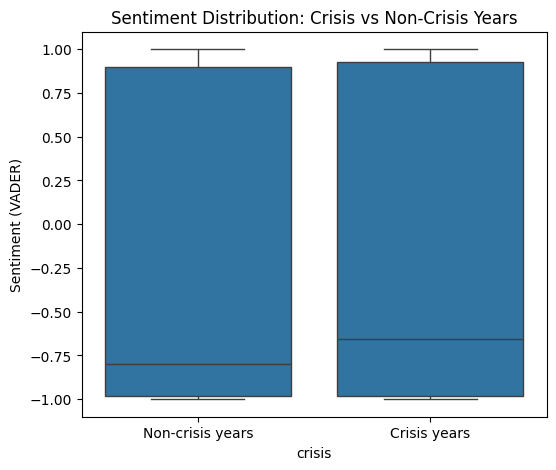

In [34]:
crisis_years = [
    1991,  # Gulf War
    2001,  # 9/11
    2008, 2009,  # Financial crisis
    2020, 2021  # COVID
]

df_top["crisis"] = df_top["year"].isin(crisis_years)

plt.figure(figsize=(6,5))
sns.boxplot(
    data=df_top,
    x="crisis",
    y="sentiment"
)

plt.xticks([0,1], ["Non-crisis years", "Crisis years"])
plt.title("Sentiment Distribution: Crisis vs Non-Crisis Years")
plt.ylabel("Sentiment (VADER)")
plt.show()


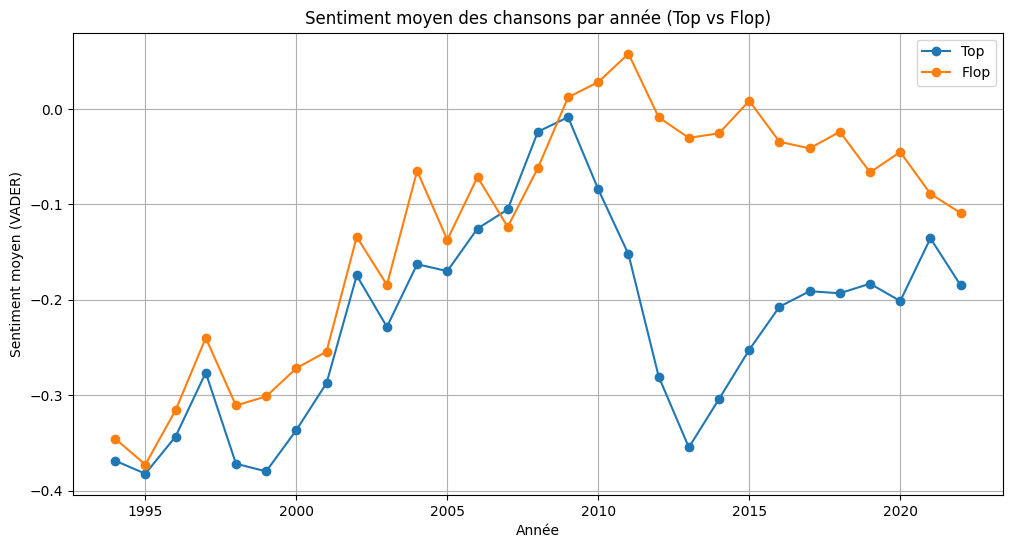

In [8]:
sentiment_top = df_top.groupby("year")["sentiment"].mean()
sentiment_flop = df_flop.groupby("year")["sentiment"].mean()

plt.figure(figsize=(12, 6))
plt.plot(sentiment_top.index, sentiment_top.values, marker="o", label="Top")
plt.plot(sentiment_flop.index, sentiment_flop.values, marker="o", label="Flop")

plt.title("Sentiment moyen des chansons par année (Top vs Flop)")
plt.xlabel("Année")
plt.ylabel("Sentiment moyen (VADER)")
plt.legend()
plt.grid(True)
plt.show()

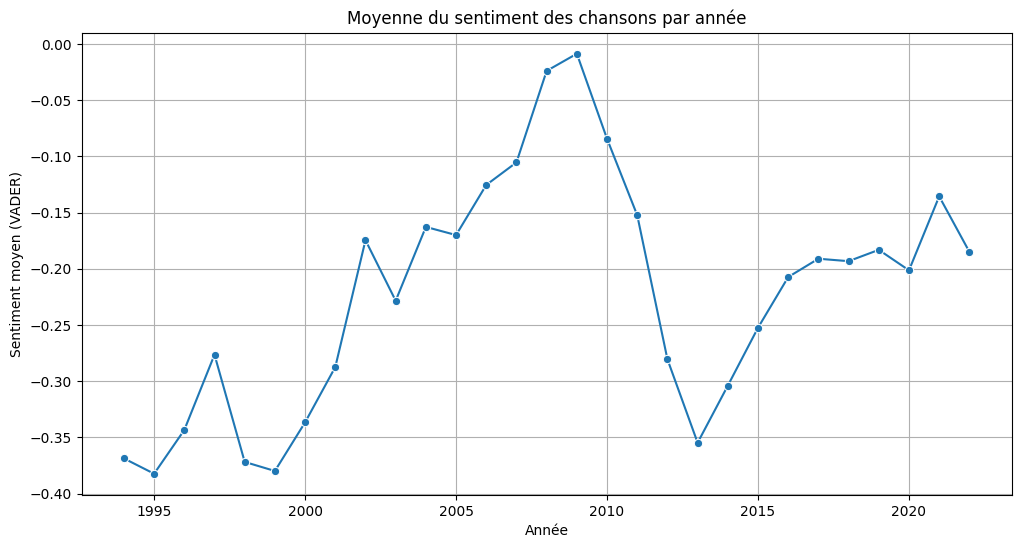

In [6]:
sentiment_year = df_top.groupby("year")["sentiment"].mean()

plt.figure(figsize=(12,6))
sns.lineplot(x=sentiment_year.index, y=sentiment_year.values, marker="o")
plt.title("Moyenne du sentiment des chansons par année")
plt.xlabel("Année")
plt.ylabel("Sentiment moyen (VADER)")
plt.grid(True)
plt.show()

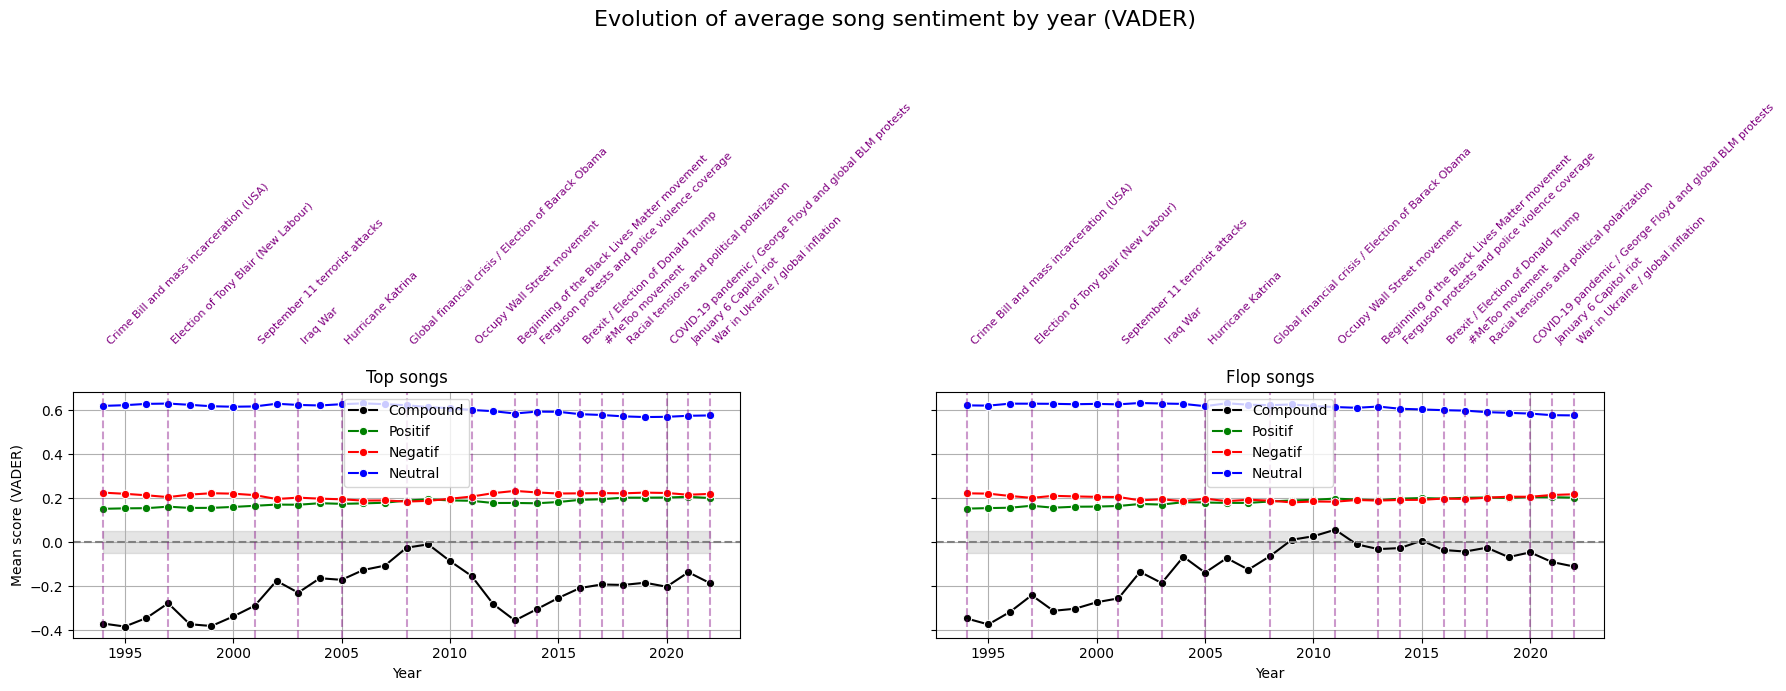

In [10]:
# Event years
us_event_years = {
    1980: "Election of Ronald Reagan (neoliberal shift)",
    1981: "AIDS crisis (public recognition)",
    1984: "Thatcher–Reagan era – economic deregulation",
    1989: "Fall of the Berlin Wall (end of the Cold War)",
    1991: "Gulf War",
    1992: "Los Angeles riots (Rodney King)",
    1994: "Crime Bill and mass incarceration (USA)",
    1997: "Election of Tony Blair (New Labour)",
    2001: "September 11 terrorist attacks",
    2003: "Iraq War",
    2005: "Hurricane Katrina",
    2008: "Global financial crisis / Election of Barack Obama",
    2011: "Occupy Wall Street movement",
    2013: "Beginning of the Black Lives Matter movement",
    2014: "Ferguson protests and police violence coverage",
    2016: "Brexit / Election of Donald Trump",
    2017: "#MeToo movement",
    2018: "Racial tensions and political polarization",
    2020: "COVID-19 pandemic / George Floyd and global BLM protests",
    2021: "January 6 Capitol riot",
    2022: "War in Ukraine / global inflation"
}

# Comparison between top and flop
cols = ["sentiment", "sentiment_pos", "sentiment_neg", "sentiment_neu"]

sent_top = (
    df_top
    .groupby("year")[cols]
    .mean()
    .reset_index()
    .assign(type="Top")
)

sent_flop = (
    df_flop
    .groupby("year")[cols]
    .mean()
    .reset_index()
    .assign(type="Flop")
)

sentiment_by_year = pd.concat([sent_top, sent_flop], ignore_index=True)

fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True)

for ax, label in zip(axes, ["Top", "Flop"]):
    data = sentiment_by_year[sentiment_by_year["type"] == label]

    sns.lineplot(
        data=data,
        x="year",
        y="sentiment",
        marker="o",
        color="black",
        label="Compound",
        ax=ax
    )
    sns.lineplot(
        data=data,
        x="year",
        y="sentiment_pos",
        marker="o",
        color="green",
        label="Positif",
        ax=ax
    )
    sns.lineplot(
        data=data,
        x="year",
        y="sentiment_neg",
        marker="o",
        color="red",
        label="Negatif",
        ax=ax
    )
    sns.lineplot(
        data=data,
        x="year",
        y="sentiment_neu",
        marker="o",
        color="blue",
        label="Neutral",
        ax=ax
    )

    ax.axhline(0, color="gray", linestyle="--")
    ax.fill_between(
        data["year"].unique(),
        -0.05, 0.05,
        color="gray", alpha=0.2
    )

    for year, event in us_event_years.items():
        if year in data["year"].values:
            ax.axvline(year, color="purple", linestyle="--", alpha=0.4)
            ax.text(year + 0.1, 0.9, event, rotation=45,
                    fontsize=8, color="purple")

    ax.set_title(f"{label} songs")
    ax.set_xlabel("Year")
    ax.grid(True)

axes[0].set_ylabel("Mean score (VADER)")
fig.suptitle("Evolution of average song sentiment by year (VADER)", fontsize=16)
plt.tight_layout()
plt.show()

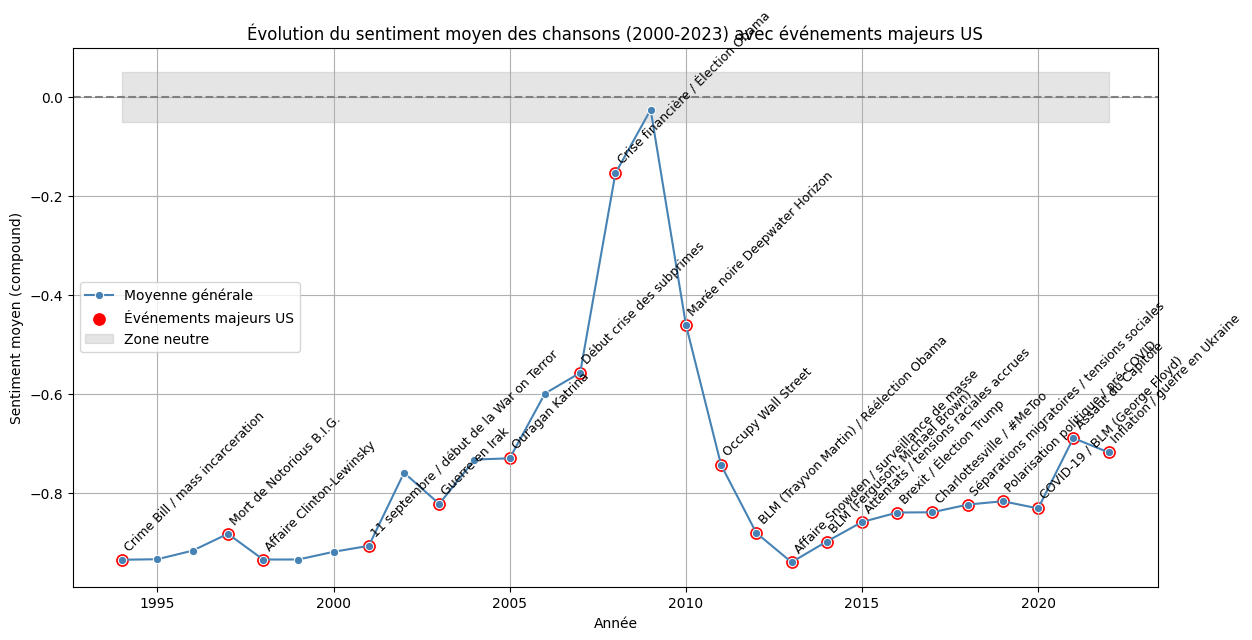

In [7]:
# Calcul du sentiment moyen par année pour tout le df_top
sentiment_year = df_top.groupby("year")["sentiment"].median()

# Filtrer le df pour les années des événements US
us_event_years = {
    # Années 1980
    1984: "Guerre contre la drogue (Reagan)",
    1989: "Fin de la Guerre froide / montée des inégalités",
    # Années 1990
    1991: "Guerre du Golfe",
    1992: "Émeutes de Los Angeles (Rodney King)",
    1994: "Crime Bill / mass incarceration",
    1997: "Mort de Notorious B.I.G.",
    1998: "Affaire Clinton-Lewinsky",
    # Années 2000
    2001: "11 septembre / début de la War on Terror",
    2003: "Guerre en Irak",
    2005: "Ouragan Katrina",
    2007: "Début crise des subprimes",
    2008: "Crise financière / Élection Obama",
    # Années 2010
    2010: "Marée noire Deepwater Horizon",
    2011: "Occupy Wall Street",
    2012: "BLM (Trayvon Martin) / Réélection Obama",
    2013: "Affaire Snowden / surveillance de masse",
    2014: "BLM (Ferguson, Michael Brown)",
    2015: "Attentats / tensions raciales accrues",
    2016: "Brexit / Élection Trump",
    2017: "Charlottesville / #MeToo",
    2018: "Séparations migratoires / tensions sociales",
    2019: "Polarisation politique / pré-COVID",
    # Années 2020
    2020: "COVID-19 / BLM (George Floyd)",
    2021: "Assaut du Capitole",
    2022: "Inflation / guerre en Ukraine",
    2023: "Crise du coût de la vie / tensions géopolitiques"
}

df_us_events = df_top[df_top["year"].isin(us_event_years.keys())]
sentiment_us_events = df_us_events.groupby("year")["sentiment"].median()

# Graphique
plt.figure(figsize=(14,7))

# Ligne sentiment moyen général
sns.lineplot(x=sentiment_year.index, y=sentiment_year.values, marker="o", color="steelblue", label="Moyenne générale")

# Points pour années clés US
sns.scatterplot(x=sentiment_us_events.index, y=sentiment_us_events.values, color="red", s=100, label="Événements majeurs US")

# Ajouter les annotations pour chaque événement
for year, event in us_event_years.items():
    if year in sentiment_us_events.index:
        plt.text(year, sentiment_us_events.loc[year] + 0.02, event, rotation=45, fontsize=9, ha='left')

# Ligne neutre
plt.axhline(0, color="gray", linestyle="--")
plt.fill_between(sentiment_year.index, -0.05, 0.05, color="gray", alpha=0.2, label="Zone neutre")

# Labels et titre
plt.title("Évolution du sentiment moyen des chansons (2000-2023) avec événements majeurs US")
plt.xlabel("Année")
plt.ylabel("Sentiment moyen (compound)")
plt.legend()
plt.grid(True)
plt.show()

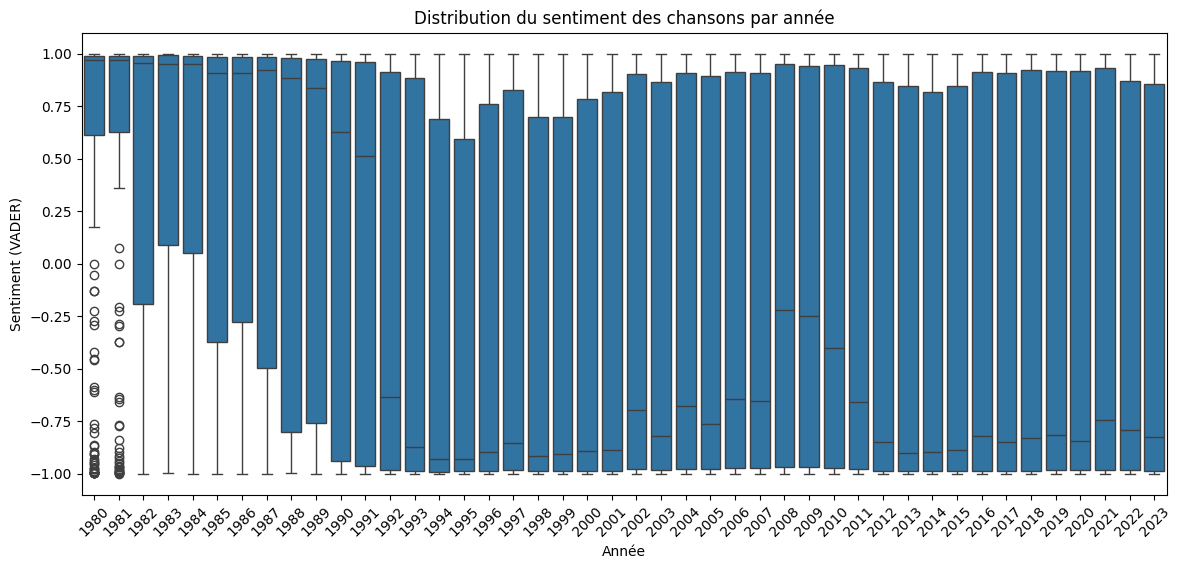

In [38]:
# Boxplots per year
plt.figure(figsize=(14,6))
sns.boxplot(x="year", y="sentiment", data=df_top)
plt.title("Distribution du sentiment des chansons par année")
plt.xlabel("Année")
plt.ylabel("Sentiment (VADER)")
plt.xticks(rotation=45)
plt.show()

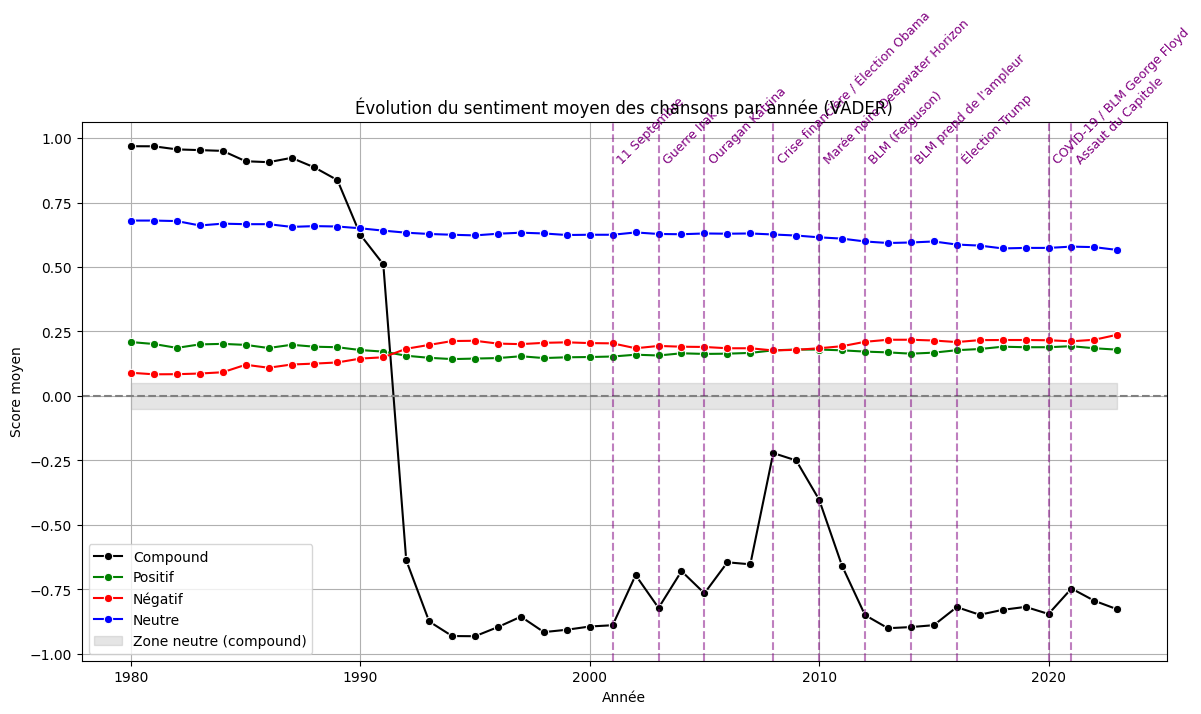

In [42]:
# Scores mean/median per years
sentiment_by_year = df_top.groupby("year")[
    ["sentiment", "sentiment_pos", "sentiment_neg", "sentiment_neu"]
].median()

plt.figure(figsize=(14,7))

sns.lineplot(x=sentiment_by_year.index, y=sentiment_by_year["sentiment"], 
             marker="o", color="black", label="Compound")
sns.lineplot(x=sentiment_by_year.index, y=sentiment_by_year["sentiment_pos"], 
             marker="o", color="green", label="Positif")
sns.lineplot(x=sentiment_by_year.index, y=sentiment_by_year["sentiment_neg"], 
             marker="o", color="red", label="Négatif")
sns.lineplot(x=sentiment_by_year.index, y=sentiment_by_year["sentiment_neu"], 
             marker="o", color="blue", label="Neutre")

plt.axhline(0, color="gray", linestyle="--")
plt.fill_between(sentiment_by_year.index, -0.05, 0.05, color="gray", alpha=0.2, label="Zone neutre (compound)")

us_event_years = {
    2001: "11 Septembre",
    2003: "Guerre Irak",
    2005: "Ouragan Katrina",
    2008: "Crise financière / Élection Obama",
    2010: "Marée noire Deepwater Horizon",
    2012: "BLM (Ferguson)",
    2014: "BLM prend de l'ampleur",
    2016: "Élection Trump",
    2020: "COVID-19 / BLM George Floyd",
    2021: "Assaut du Capitole"
}
for year, event in us_event_years.items():
    if year in sentiment_by_year.index:
        plt.axvline(year, color="purple", linestyle="--", alpha=0.5)
        plt.text(year+0.1, 0.9, event, rotation=45, fontsize=9, color="purple")

plt.title("Évolution du sentiment moyen des chansons par année (VADER)")
plt.xlabel("Année")
plt.ylabel("Score moyen")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Mean and median of Vader scores per year
sentiment_stats = df_top.groupby("year")[["sentiment", "sentiment_pos", "sentiment_neg", "sentiment_neu"]].agg(
    ["mean", "median"]
)

print(sentiment_stats)

     sentiment          sentiment_pos         sentiment_neg          \
          mean   median          mean  median          mean  median   
year                                                                  
2000 -0.382867 -0.92145      0.161279  0.1495      0.222041  0.2145   
2001 -0.283030 -0.90620      0.162769  0.1535      0.215889  0.2045   
2002 -0.146547 -0.68080      0.176817  0.1630      0.198195  0.1885   
2003 -0.123873 -0.63305      0.189087  0.1685      0.194889  0.1865   
2004 -0.159701 -0.74300      0.176493  0.1650      0.193930  0.1870   
2005 -0.094373 -0.56160      0.185918  0.1730      0.190788  0.1820   
2006 -0.156108 -0.67050      0.176974  0.1665      0.192647  0.1875   
2007  0.015869  0.14030      0.193983  0.1845      0.181091  0.1690   
2008  0.023268  0.11915      0.199192  0.1875      0.181654  0.1720   
2009 -0.062020 -0.39580      0.197517  0.1895      0.198060  0.1875   
2010 -0.098984 -0.52580      0.195856  0.1880      0.204351  0.2005   
2011 -

## Analysis emotional power - NRC

In [52]:
# Charger le lexique
nrc = pd.read_csv(
    "NRC-Emotion-Lexicon-Wordlevel-v0.92.txt",
    sep="\t",
    names=["word", "emotion", "association"]
)

# On ne garde que les mots associés à une émotion
nrc = nrc[nrc["association"] == 1]

# Créer un dictionnaire {mot: [emotions]}
from collections import defaultdict

nrc_dict = defaultdict(list)
for _, row in nrc.iterrows():
    nrc_dict[row["word"]].append(row["emotion"])

In [ ]:
def nrc_score(text, lexicon=nrc_dict):
    tokens = text.lower().split()  # on tokenise simplement par espace
    emotion_counts = Counter()
    
    for token in tokens:
        for emotion in lexicon.get(token, []):
            emotion_counts[emotion] += 1
    
    total = sum(emotion_counts.values())
    if total == 0:
        # Aucun mot associé trouvé, on retourne 0 pour chaque émotion
        return {e: 0 for e in [
            "anger","anticipation","disgust","fear","joy",
            "sadness","surprise","trust","positive","negative"
        ]}
    
    # Normaliser par le total
    return {k: v/total for k, v in emotion_counts.items()}


In [54]:
# Limiter éventuellement à 1000 mots par texte pour accélérer
df_top["nrc_scores"] = df_top["clean_lyrics"].apply(lambda x: nrc_score(x[:1000]))

# Convertir en colonnes séparées
nrc_df = df_top["nrc_scores"].apply(pd.Series)
df_top = pd.concat([df_top, nrc_df], axis=1)

# Exemple : voir les 5 premières lignes
df_top[["anger","joy","sadness","positive","negative"]].head()

,anger,joy,sadness,positive,negative
0,0.088608,0.063291,0.037975,0.126582,0.101266
1,0.028986,0.246377,0.043478,0.289855,0.086957
2,0.104167,0.052083,0.093750,0.093750,0.229167
3,0.074468,0.117021,0.074468,0.255319,0.085106
4,0.050000,0.087500,0.025000,0.350000,0.050000


In [55]:
# Convertir en colonnes séparées
nrc_df = df_top["nrc_scores"].apply(pd.Series)
df_top = pd.concat([df_top, nrc_df], axis=1)

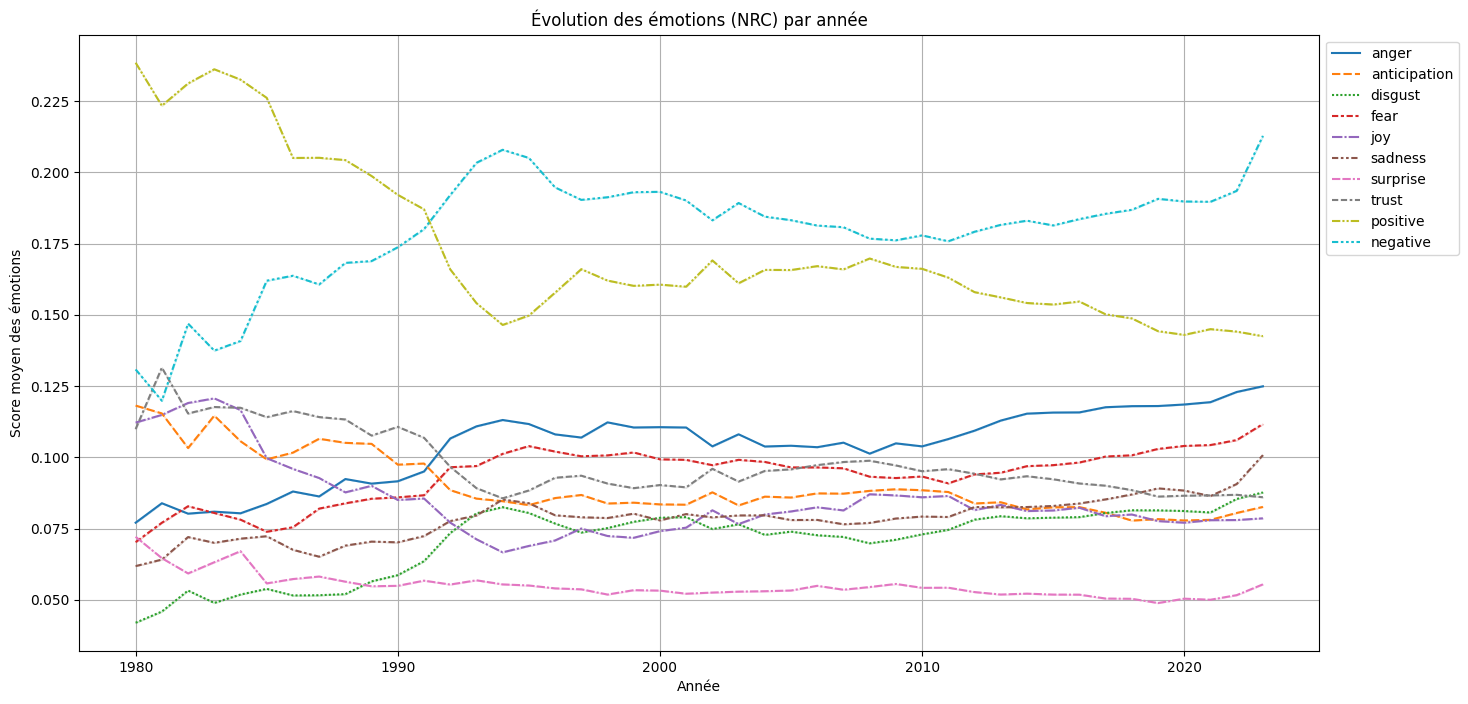

In [56]:
# Moyenne par année
emotion_year = df_top.groupby("year")[
    ["anger","anticipation","disgust","fear","joy","sadness","surprise","trust","positive","negative"]
].mean()

plt.figure(figsize=(16,8))
sns.lineplot(data=emotion_year)
plt.title("Évolution des émotions (NRC) par année")
plt.xlabel("Année")
plt.ylabel("Score moyen des émotions")
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.grid(True)
plt.show()

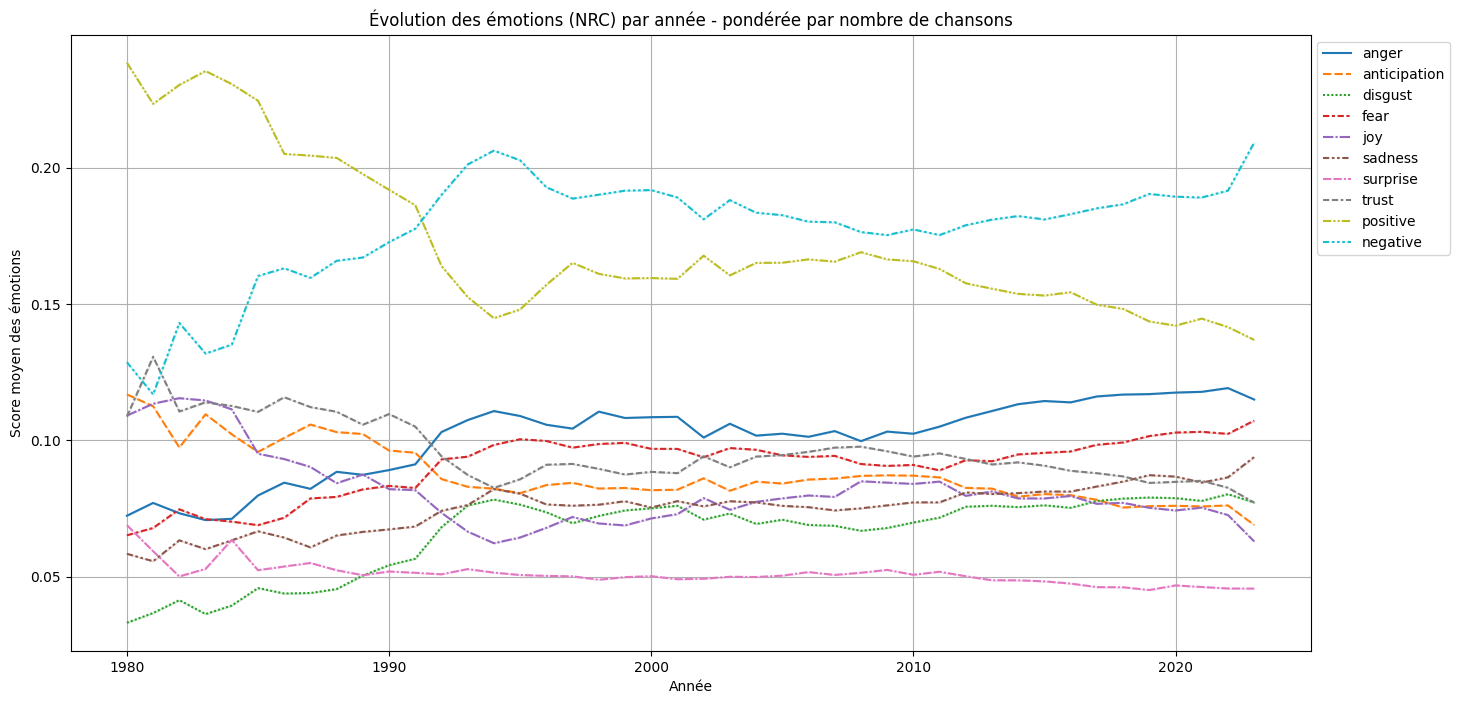

In [ ]:
# Colonnes NRC
nrc_cols = ["anger","anticipation","disgust","fear","joy",
            "sadness","surprise","trust","positive","negative"]

# Calcul du nombre de chansons par année
count_per_year = df_top.groupby("year").size()

# Somme des émotions par année
sum_emotions_per_year = df_top.groupby("year")[nrc_cols].sum()

# Moyenne pondérée en divisant par le nombre de chansons par année
emotion_year_p = sum_emotions_per_year.div(count_per_year, axis=0)

# Graphique
plt.figure(figsize=(16,8))
sns.lineplot(data=emotion_year_p)
plt.title("Évolution des émotions (NRC) par année - pondérée par nombre de chansons")
plt.xlabel("Année")
plt.ylabel("Score moyen des émotions")
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.grid(True)
plt.show()

## LDA

In [4]:
# Configuration du CountVectorizer
cv = CountVectorizer(
    max_df=0.9,           # Ignore les mots dans >90% des documents
    min_df=2,             # Ignore les mots apparaissant <2 fois
    stop_words='english'  # Retire les stop words anglais
)

print("CountVectorizer configuré")
print(f"  - max_df: {cv.max_df} (mots trop fréquents exclus)")
print(f"  - min_df: {cv.min_df} (mots trop rares exclus)")
print(f"  - stop_words: {len(cv.get_stop_words())} mots exclus")

CountVectorizer configuré
  - max_df: 0.9 (mots trop fréquents exclus)
  - min_df: 2 (mots trop rares exclus)
  - stop_words: 318 mots exclus


In [5]:
# Construction de la matrice Document-Terme
dtm = cv.fit_transform(df_top['clean_lyrics'])

print(f"Matrice Document-Terme créée")
print(f"  - Forme: {dtm.shape} (documents x vocabulaire)")
print(f"  - {dtm.shape[0]} documents")
print(f"  - {dtm.shape[1]} mots dans le vocabulaire")
print(f"  - Type: {type(dtm)} (matrice sparse pour économie mémoire)")

Matrice Document-Terme créée
  - Forme: (116331, 110275) (documents x vocabulaire)
  - 116331 documents
  - 110275 mots dans le vocabulaire
  - Type: <class 'scipy.sparse._csr.csr_matrix'> (matrice sparse pour économie mémoire)


### LDA training

In [ ]:
# Initialisation du modèle LDA
LDA = LatentDirichletAllocation(
    n_components=20,      # Nombre de topics à découvrir
    random_state=42      # Pour reproductibilité
)

print("Modèle LDA initialisé avec 20 topics")

Modèle LDA initialisé avec 3 topics


In [7]:
# Entraînement du modèle
# Cela peut prendre du temps avec beaucoup de documents
print("Entraînement du modèle LDA...")
LDA.fit(dtm)
print("✓ Entraînement terminé !")

Entraînement du modèle LDA...


KeyboardInterrupt: 

In [8]:
# Test sur sous-échantillon
dtm_small = dtm[:20000]
LDA.fit(dtm_small)

,"n_components n_components: int, default=10Number of topics... versionchanged:: 0.19 ``n_topics`` was renamed to ``n_components``",50
,"doc_topic_prior doc_topic_prior: float, default=NonePrior of document topic distribution `theta`. If the value is None,defaults to `1 / n_components`.In [1]_, this is called `alpha`.",None
,"topic_word_prior topic_word_prior: float, default=NonePrior of topic word distribution `beta`. If the value is None, defaultsto `1 / n_components`.In [1]_, this is called `eta`.",None
,"learning_method learning_method: {'batch', 'online'}, default='batch'Method used to update `_component`. Only used in :meth:`fit` method.In general, if the data size is large, the online update will be muchfaster than the batch update.Valid options:- 'batch': Batch variational Bayes method. Use all training data in each EM update. Old `components_` will be overwritten in each iteration.- 'online': Online variational Bayes method. In each EM update, use mini-batch of training data to update the ``components_`` variable incrementally. The learning rate is controlled by the ``learning_decay`` and the ``learning_offset`` parameters... versionchanged:: 0.20 The default learning method is now ``""batch""``.",'batch'
,"learning_decay learning_decay: float, default=0.7It is a parameter that control learning rate in the online learningmethod. The value should be set between (0.5, 1.0] to guaranteeasymptotic convergence. When the value is 0.0 and batch_size is``n_samples``, the update method is same as batch learning. In theliterature, this is called kappa.",0.7
,"learning_offset learning_offset: float, default=10.0A (positive) parameter that downweights early iterations in onlinelearning. It should be greater than 1.0. In the literature, this iscalled tau_0.",10.0
,"max_iter max_iter: int, default=10The maximum number of passes over the training data (aka epochs).It only impacts the behavior in the :meth:`fit` method, and not the:meth:`partial_fit` method.",10
,"batch_size batch_size: int, default=128Number of documents to use in each EM iteration. Only used in onlinelearning.",128
,"evaluate_every evaluate_every: int, default=-1How often to evaluate perplexity. Only used in `fit` method.set it to 0 or negative number to not evaluate perplexity intraining at all. Evaluating perplexity can help you check convergencein training process, but it will also increase total training time.Evaluating perplexity in every iteration might increase training timeup to two-fold.",-1
,"total_samples total_samples: int, default=1e6Total number of documents. Only used in the :meth:`partial_fit` method.",1000000.0
,"perp_tol perp_tol: float, default=1e-1Perplexity tolerance. Only used when ``evaluate_every`` is greater than 0.",0.1


In [9]:
# Extraction du premier topic
single_topic = LDA.components_[0]
print(f"Topic 0 - Distribution sur {len(single_topic)} mots")

Topic 0 - Distribution sur 110275 mots


In [10]:
top_ten_words = single_topic.argsort()[-10:]

In [11]:
# Conversion des indices en mots
print("\nTop 10 mots du Topic 0:")
for index in top_ten_words:
    word = cv.get_feature_names_out()[index]
    prob = single_topic[index]
    print(f"  - {word:<20} (probabilité: {prob:.4f})")


Top 10 mots du Topic 0:
  - master               (probabilité: 626.9376)
  - funky                (probabilité: 631.2165)
  - rhymes               (probabilité: 642.6177)
  - know                 (probabilité: 665.8548)
  - beat                 (probabilité: 776.6686)
  - bass                 (probabilité: 906.0501)
  - fresh                (probabilité: 1029.3329)
  - cause                (probabilité: 1250.5149)
  - rhyme                (probabilité: 1417.4014)
  - boogie               (probabilité: 1492.8365)


In [ ]:
# Boucle sur tous les topics
print("=" * 70)
print("TOPICS DÉCOUVERTS PAR LDA")
print("=" * 70)

for i, topic in enumerate(LDA.components_):
    print(f"\nTOPIC #{i}")
    print("-" * 70)
    top_words = [cv.get_feature_names_out()[idx] for idx in topic.argsort()[-15:]]
    print("Top 15 mots:", ', '.join(top_words))

print("\n" + "=" * 70)

TOPICS DÉCOUVERTS PAR LDA

TOPIC #0
----------------------------------------------------------------------
Top 15 mots: way, jam, like, run, posse, master, funky, rhymes, know, beat, bass, fresh, cause, rhyme, boogie

→ Interprétation suggérée: [À compléter manuellement]

TOPIC #1
----------------------------------------------------------------------
Top 15 mots: yah, man, cause, rock, come, soul, hah, wreck, like, yeah, got, know, hop, hip, check

→ Interprétation suggérée: [À compléter manuellement]

TOPIC #2
----------------------------------------------------------------------
Top 15 mots: hell, train, got, ways, choo, bum, million, bout, triple, dollar, woo, cash, livin, ride, money

→ Interprétation suggérée: [À compléter manuellement]

TOPIC #3
----------------------------------------------------------------------
Top 15 mots: cause, make, wonder, better, like, respect, friends, think, dead, know, life, gangsta, got, ghetto, world

→ Interprétation suggérée: [À compléter manuell